                            OLS Regression Results                            
Dep. Variable:     log_GDP_per_capita   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.099
Method:                 Least Squares   F-statistic:                   0.01204
Date:                Thu, 06 Nov 2025   Prob (F-statistic):              0.915
Time:                        10:36:05   Log-Likelihood:                -12.673
No. Observations:                  12   AIC:                             29.35
Df Residuals:                      10   BIC:                             30.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.4866      0.472     22.212      

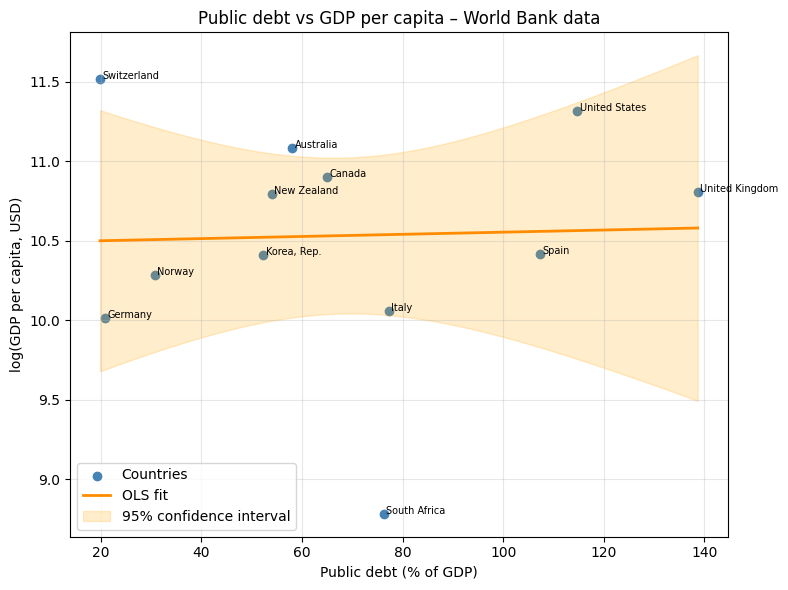

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import wbdata

# =========================
# 1) Indicatori e paesi
# =========================
indicators = {
    "GC.DOD.TOTL.GD.ZS": "Debt_to_GDP",  # debito pubblico (% PIL)
    "NY.GDP.PCAP.CD": "GDP_per_capita_USD",  # PIL pro capite (USD correnti)
}

countries = [
    "USA",
    "CAN",
    "GBR",
    "FRA",
    "DEU",
    "ITA",
    "ESP",
    "JPN",
    "AUS",
    "NZL",
    "CHE",  # Svizzera
    "NOR",
    "SWE",
    "KOR",
    "ZAF",
]

# =========================
# 2) Scarico dati (tutti gli anni disponibili)
# =========================
# versione compatibile: NIENTE convert_date, NIENTE data_date
df = wbdata.get_dataframe(indicators, country=countries)

# df ha un MultiIndex (country, date) → lo porto a colonne
df = (
    df.reset_index()
)  # ora ho colonne: 'country', 'date', 'Debt_to_GDP', 'GDP_per_capita_USD'

# rinomino per coerenza
df = df.rename(columns={"country": "Country", "date": "Year"})

# elimino righe senza almeno una delle due variabili
df = df.dropna(subset=["Debt_to_GDP", "GDP_per_capita_USD"])

# la colonna Year è una stringa tipo "2022" → la trasformo in int
# (alcune righe potrebbero avere cose strane: mettiamo errors='coerce')
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"])
df["Year"] = df["Year"].astype(int)

# =========================
# 3) Per ogni paese prendo l'anno più recente
# =========================
df = (
    df.sort_values(["Country", "Year"], ascending=[True, False])
    .groupby("Country", as_index=False)
    .first()
)

# se ti accorgi che rimangono pochi paesi, è perché alcuni non hanno l'indicatore di debito

# =========================
# 4) Regressione
# =========================
df["log_GDP_per_capita"] = np.log(df["GDP_per_capita_USD"])

X = sm.add_constant(df["Debt_to_GDP"])
y = df["log_GDP_per_capita"]

model = sm.OLS(y, X).fit()
print(model.summary())

# =========================
# 5) Predizione per tracciare la retta + CI
# =========================
x_line = np.linspace(df["Debt_to_GDP"].min(), df["Debt_to_GDP"].max(), 100)
X_pred = sm.add_constant(x_line)
pred = model.get_prediction(X_pred).summary_frame(alpha=0.05)

# =========================
# 6) Plot
# =========================
plt.figure(figsize=(8, 6))

plt.scatter(
    df["Debt_to_GDP"], df["log_GDP_per_capita"], color="steelblue", label="Countries"
)

plt.plot(x_line, pred["mean"], color="darkorange", linewidth=2, label="OLS fit")

plt.fill_between(
    x_line,
    pred["mean_ci_lower"],
    pred["mean_ci_upper"],
    color="orange",
    alpha=0.2,
    label="95% confidence interval",
)

# etichette con il nome del paese
for _, row in df.iterrows():
    plt.text(
        row["Debt_to_GDP"] + 0.5, row["log_GDP_per_capita"], row["Country"], fontsize=7
    )

plt.xlabel("Public debt (% of GDP)")
plt.ylabel("log(GDP per capita, USD)")
plt.title("Public debt vs GDP per capita – World Bank data")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()